<!-- Centered layout with a university logo -->
<div align="center">

  <!-- University Logo -->
  <img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width="180" height="180" style="margin-bottom: 10px;">
  
  <!-- Assignment Title -->
  <h1></h1>
  <h1 style="color:#0F5298; font-size: 40px; font-weight: bold; margin-bottom: 5px;">Deep Reinforcement Learning</h1>
  <h2 style="color:#0F5298; font-size: 32px; font-weight: normal; margin-top: 0px;">Assignment 06 - Multi-Armed and Contextual Bandits</h2>

  <!-- Department and University -->
  <h3 style="color:#696880; font-size: 24px; margin-top: 20px;">Computer Engineering Department</h3>
  <h3 style="color:#696880; font-size: 22px; margin-top: -5px;">Sharif University of Technology</h3>

  <!-- Semester -->
  <h3 style="color:#696880; font-size: 22px; margin-top: 20px;">Spring 2025</h3>

  <!-- Authors -->
  <h3 style="color:green; font-size: 22px; margin-top: 20px;">Full name: Amir Kooshan Fattah Hesari</h3>
  <h3 style="color:green; font-size: 22px; margin-top: 20px;">Student ID: 401102191</h3>

  <!-- Horizontal Line for Separation -->
  <hr style="border: 1px solid #0F5298; width: 80%; margin-top: 30px;">

</div>


## Setup & Overview  
In this notebook, we simulate bandit problems using *MAB* (Multi-Armed Bandit) and *CtxBnd* (Contextual Bandit) frameworks.  
We compare several agents:
- **Oracle** (with privileged info)
- **RndAg** (Random Agent)
- **ExpFstAg** (Explore-First Agent)
- **UCB_Ag** (UCB Agent)
- **EpsGdAg** (Epsilon-Greedy Agent)
- **LinUCB_Ag** (LinUCB for contextual bandits)


Follow the instructions carefully and complete the sections marked with **TODO**.

## Setup and Environment

In the upcoming cells, we import necessary libraries, set up utility functions for reproducibility and plotting, and define the basic components of our bandit experiments.


In [1]:
# %% [code]
import numpy as np
import random
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from dataclasses import dataclass
from copy import deepcopy
from tqdm.notebook import tqdm

plt.rcParams['figure.dpi'] = 100

In [2]:
import warnings
warnings.filterwarnings("ignore" , category = FutureWarning)

In [3]:
# %% [code]
def plot_logs(df, x_key, y_key, legend_key, **kwargs):
    num = len(df[legend_key].unique())
    pal = sns.color_palette("hls", num)
    if 'palette' not in kwargs:
        kwargs['palette'] = pal
    ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)
    return ax

def set_seed(s):
    np.random.seed(s)
    random.seed(s)

set_seed(0)

## MAB Overview  
We consider a bandit with 10 arms. Two formulations:  
- **Stochastic:** Each arm gives a reward of 1 with probability *p*.  
- **Deterministic:** Each arm always returns a fixed reward.  
  
We'll work with the stochastic case. The reward probabilities will be set randomly.

In [4]:
# %% [code]
nArms = 10
p_arr = [np.random.random() for _ in range(nArms)]
print("Probabilities:", p_arr)

Probabilities: [0.5488135039273248, 0.7151893663724195, 0.6027633760716439, 0.5448831829968969, 0.4236547993389047, 0.6458941130666561, 0.4375872112626925, 0.8917730007820798, 0.9636627605010293, 0.3834415188257777]


**Q:** How might the performance of different agents change if the distribution of probabilities were not uniform?  

**A:** In general, agents that balance exploration and exploitation, like UCB or Thompson Sampling, tend to perform better in non-uniform reward distributions, while agents that rely on fixed exploration rates or random exploration will struggle.


In [5]:
# %% [code]
@dataclass
class MAB_Env:
    p_arr: np.ndarray

    def step(self, act):
        return 1 if np.random.random() < self.p_arr[act] else 0

**Q:** Why does the MAB environment use a simple binary reward mechanism (1 or 0)?

**A:** With binary rewards, the complexity of reward distribution is removed, allowing researchers and practitioners to focus on the effectiveness of different exploration-exploitation strategies

In [6]:
# %% [code]
@dataclass
class MAB_Eng:
    p_arr: np.ndarray
    max_steps: int
    agent: any

    def __post_init__(self):
        self.env = MAB_Env(p_arr=self.p_arr)

    def run(self, n_runs=1):
        logs = []
        for _ in tqdm(range(n_runs), desc='Runs'):
            run_rewards = []
            run_acts = []
            self.agent.reset()
            for t in range(self.max_steps):
                act = self.agent.get_action()
                rew = self.env.step(act)
                self.agent.update_Q(act, rew)
                run_acts.append(act)
                run_rewards.append(rew)
            logs.append(pd.DataFrame({
                'reward': run_rewards,
                'action': run_acts,
                'step': np.arange(len(run_rewards))
            }))
        return pd.concat(logs, ignore_index=True)

In [7]:
# %% [code]
def mab_swp(agents, p_arr, labels, n_runs=2000, max_steps=500):
    all_logs = []
    for idx, agent in enumerate(tqdm(agents, desc="Alg Sweeps")):
        engine = MAB_Eng(p_arr=p_arr, max_steps=max_steps, agent=agent)
        log_df = engine.run(n_runs)
        log_df['Alg'] = labels[idx]
        all_logs.append(log_df)
    return pd.concat(all_logs, ignore_index=True)

## Oracle Agent  
The **Oracle** has full knowledge of *p_arr*.  
**Question:** What is the maximum expected per-step reward?

In [8]:
# TODO: Compute oracleReward using privileged info (simple placeholder)
oracleReward = p_arr[np.argmax(p_arr)]  # Placeholder
print(f'Max possible reward (Simple): {oracleReward}')

Max possible reward (Simple): 0.9636627605010293


**Q:** What insight does the oracle reward give us about the best possible performance?

**A:** in the report

-------------------

**Q:** Why is the oracle considered “cheating” in a practical sense?  

**A:** in the report

## RndAg (Random Agent)  
This agent selects an action at random at every timestep. It does no learning.


In [9]:
@dataclass
class RndAg:
    n_act: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.t = 0
        self.act_counts = np.zeros(self.n_act, dtype=int)
        self.Q = np.zeros(self.n_act, dtype=float)

    def update_Q(self, act, rew):
        pass  # No learning

    def get_action(self):
        self.t += 1
        # TODO: get a random action index [Simple]
        sel_act = np.random.randint(0, self.n_act)
        return sel_act

In [10]:
# %% [code]
rnd_agent = RndAg(n_act=len(p_arr))
n_runs = 1000
rnd_log = mab_swp([rnd_agent], p_arr, ['Rnd'], n_runs=n_runs)

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

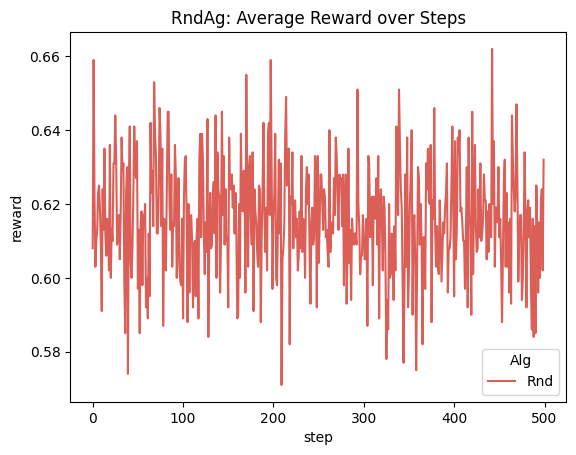

In [11]:
# %% [code]
plot_logs(rnd_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("RndAg: Average Reward over Steps")
plt.show()

**Q:** Why is the reward of the random agent generally lower and highly variable?

**A:** in the report

------------

**Q:** How might you improve a random agent without using any learning mechanism?

**A:** in the report

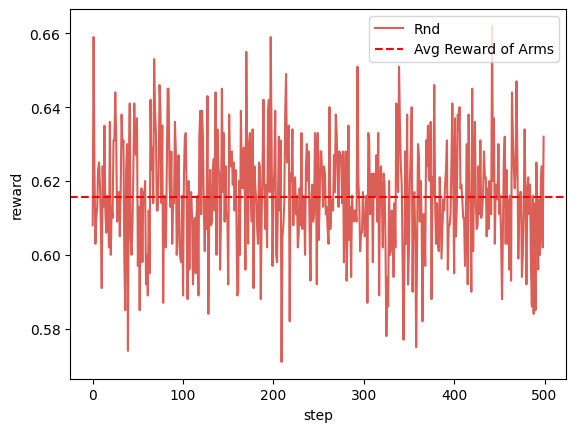

In [12]:
# Plot reward curve
plot_logs(rnd_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
# Plot average reward of all arms
avg_reward = np.mean(p_arr)
plt.axhline(avg_reward, color='red', linestyle='--', label='Avg Reward of Arms')
plt.legend()
plt.show()


**Analysis:**  
- The x-axis shows the number of steps; y-axis shows average reward.  
- Regret is the gap between Oracle and agent performance.

## ExpFstAg (Explore-First Agent)  
This agent explores randomly for the first *max_ex* steps, then exploits the best arm thereafter.

In [13]:
@dataclass
class ExpFstAg:
    n_act: int
    max_ex: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.t = 0
        self.act_counts = np.zeros(self.n_act, dtype=int)
        self.Q = np.zeros(self.n_act, dtype=float)

    def update_Q(self, act, rew):
        # Incremental update of Q
        self.act_counts[act] += 1
        n = self.act_counts[act]
        self.Q[act] += (1 / n) * (rew - self.Q[act])

    def get_action(self):
        self.t += 1
        if self.t <= self.max_ex:
            # Random exploration
            sel_act = np.random.randint(0, self.n_act)
        else:
            # Exploit best arm
            sel_act = np.argmax(self.Q)
        return sel_act


### Run ExpFstAg with max_ex = 5  
We will test ExpFstAg (with 5 exploration steps) over 1000 runs and 500 steps.

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

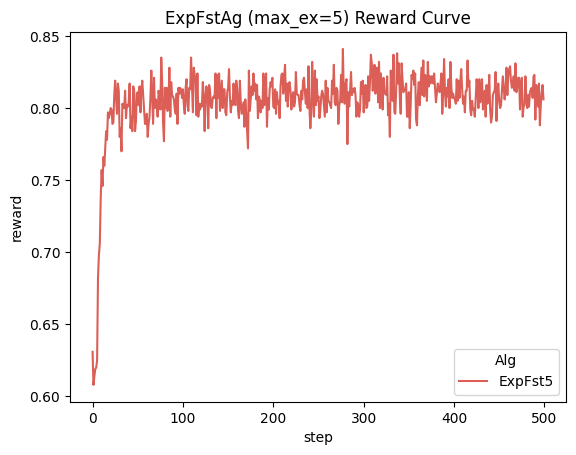

In [14]:
# %% [code]
max_ex = 5
expfst_agent = ExpFstAg(n_act=len(p_arr), max_ex=max_ex)
expfst_log = mab_swp([expfst_agent], p_arr, [f'ExpFst{max_ex}'], n_runs=1000, max_steps=500)
plot_logs(expfst_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title(f"ExpFstAg (max_ex={max_ex}) Reward Curve")
plt.show()

**Analysis:**  
- The ExpFstAg should outperform RndAg by identifying the best arm during exploration.  
- However, with too short exploration, it may miss the best arm.

----------

**Q:** Why might the early exploration phase (e.g., 5 steps) lead to high fluctuations in the reward curve?  


**A:** in the report

------------
**Q:** What are the trade-offs of using a fixed exploration phase?


**A:** in the report

Running ExpFstAg with max_ex=5...


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Running ExpFstAg with max_ex=10...


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Running ExpFstAg with max_ex=50...


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Running ExpFstAg with max_ex=100...


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Running ExpFstAg with max_ex=200...


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

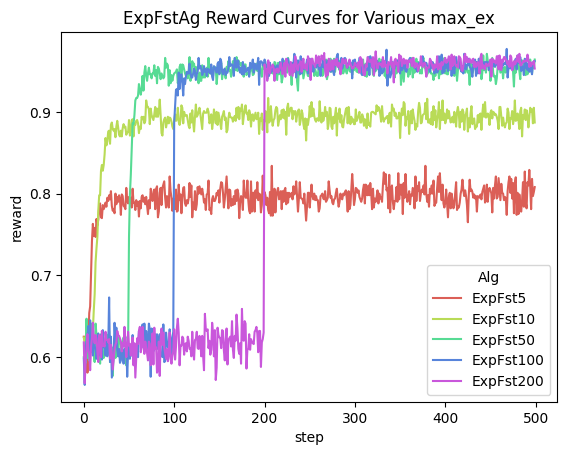

In [15]:
max_ex_list = [5, 10, 50, 100, 200]
logs = []

for ex in max_ex_list:
    print(f"Running ExpFstAg with max_ex={ex}...")
    agent = ExpFstAg(n_act=len(p_arr), max_ex=ex)
    log = mab_swp([agent], p_arr, [f'ExpFst{ex}'], n_runs=1000, max_steps=500)
    logs.append(log)

# Concatenate all logs (if your log is a DataFrame)
all_logs = pd.concat(logs)

# Plot
plot_logs(all_logs, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("ExpFstAg Reward Curves for Various max_ex")
plt.show()


**Observations:**  
- Short exploration (e.g., 5 or 10 steps) may not reliably find the best arm.  
- Longer exploration (e.g., 50 or 100 steps) improves performance but may delay exploitation.

**Q:** How does increasing `max_ex` affect the convergence of the agent’s performance?


**A:** It might take some more time , but the results are better and converge to the real value with higher `max_ex`

------------------------------

**Q:** In real-world scenarios, what challenges might arise in selecting the optimal exploration duration?

**A:** The reward distributions of the arms might change over time due to external factors or evolving system conditions, making it hard to predict the optimal exploration duration. What worked initially may no longer be optimal later.

## UCB_Ag (UCB Agent)  
UCB dynamically balances exploration and exploitation by adding an exploration bonus to Q-values.

In [16]:
@dataclass
class UCB_Ag:
    n_act: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.t = 0
        self.act_counts = np.zeros(self.n_act, dtype=int)
        self.Q = np.zeros(self.n_act, dtype=float)

    def update_Q(self, act, rew):
        # Incremental Q update
        self.act_counts[act] += 1
        n = self.act_counts[act]
        self.Q[act] += (1 / n) * (rew - self.Q[act])

    def get_action(self):
        self.t += 1
        delta = 1e-5  # to avoid log(0) or division by zero

        if 0 in self.act_counts:
            # Play untried arms first (important in UCB)
            sel_act = np.argmin(self.act_counts)
        else:
            # Compute exploration bonus
            bonus = np.sqrt(2 * np.log(self.t) / (self.act_counts + delta))
            Q_explore = self.Q + bonus
            sel_act = np.random.choice(np.flatnonzero(Q_explore == Q_explore.max()))

        return sel_act

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

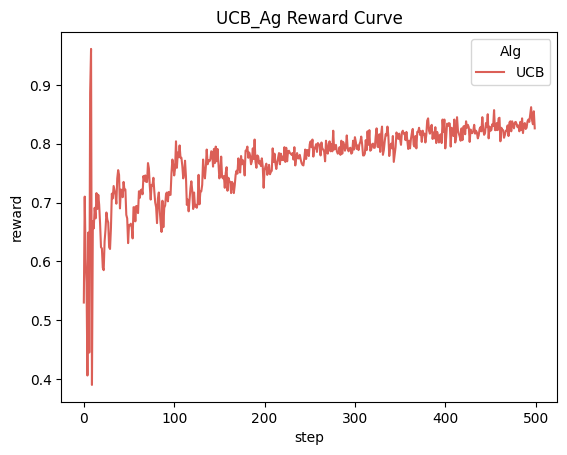

In [17]:
# %% [code]
ucb_agent = UCB_Ag(n_act=len(p_arr))
ucb_log = mab_swp([ucb_agent], p_arr, ['UCB'], n_runs=1000, max_steps=500)
plot_logs(ucb_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("UCB_Ag Reward Curve")
plt.show()

**Q:** Under what conditions might an explore-first strategy outperform UCB, despite UCB’s theoretical optimality?

**A:** The key idea is that UCB’s continual exploration might not be necessary or optimal when exploration can be done upfront in a more controlled and efficient way. More details in the report

-----------------
**Q:** How do the design choices of each algorithm affect their performance in short-term versus long-term scenarios?

**A:** Complete answer in the report

## UCB vs. ExpFstAg  
Now we compare UCB_Ag and ExpFstAg (with max_ex = 5) side by side.


**Question:**  
Why does UCB learn slowly (even after 500 steps, not reaching maximum reward)?  
because it balances exploration and exploitation, giving more weight to arms with higher uncertainty

*Hint:* Consider the conservative nature of the exploration bonus.


Running comparison...


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

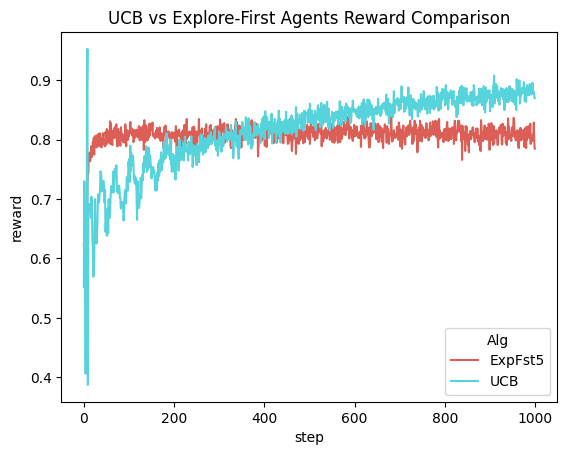

In [18]:
# Agents
expfst_agent = ExpFstAg(n_act=len(p_arr), max_ex=5)
ucb_agent = UCB_Ag(n_act=len(p_arr))
# Parameters
n_runs = 1000
max_steps = 1000
# Run experiments
print("Running comparison...")
logs = []
# ExpFst
expfst_log = mab_swp([expfst_agent], p_arr, ['ExpFst5'], n_runs=n_runs, max_steps=max_steps)
logs.append(expfst_log)
# UCB
ucb_log = mab_swp([ucb_agent], p_arr, ['UCB'], n_runs=n_runs, max_steps=max_steps)
logs.append(ucb_log)
all_logs = pd.concat(logs)

# Plot
plot_logs(all_logs, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("UCB vs Explore-First Agents Reward Comparison")
plt.show()


**Q:** Under what conditions might an explore-first strategy outperform UCB, despite UCB’s theoretical optimality?

**A:** It was addressed above and in the report , limited resource , small number of arms , etc.

---------------

**Q:** How do the design choices of each algorithm affect their performance in short-term versus long-term scenarios?

**A:** it was answer in the report thoroughly.

**Question:**  
What happens if we let ExpFstAg explore for 20 steps? Compare its reward to UCB.

Running comparison...


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

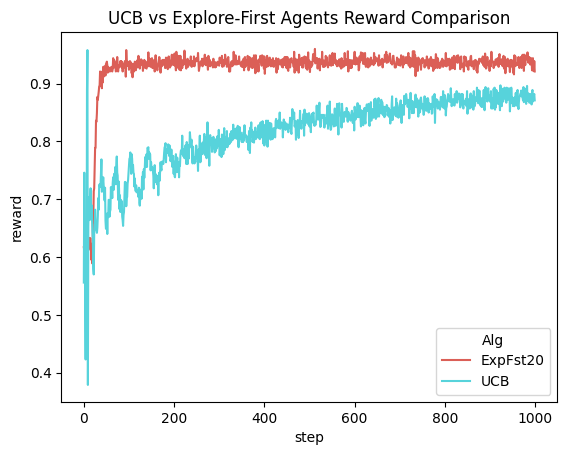

In [19]:
expfst_agent = ExpFstAg(n_act=len(p_arr), max_ex=20)
ucb_agent = UCB_Ag(n_act=len(p_arr))
# Parameters
n_runs = 1000
max_steps = 1000
# Run experiments
print("Running comparison...")
logs = []
# ExpFst
expfst_log = mab_swp([expfst_agent], p_arr, ['ExpFst20'], n_runs=n_runs, max_steps=max_steps)
logs.append(expfst_log)
# UCB
ucb_log = mab_swp([ucb_agent], p_arr, ['UCB'], n_runs=n_runs, max_steps=max_steps)
logs.append(ucb_log)
all_logs = pd.concat(logs)

# Plot
plot_logs(all_logs, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("UCB vs Explore-First Agents Reward Comparison")
plt.show()

**Q:** What impact does increasing the exploration phase to 20 steps have compared to 5 steps?

**A:** It explores more and can find the best action.

---------------

**Q:** How can you determine the optimal balance between exploration and exploitation in practice?

**A:** Finding the optimal balance is often a matter of testing different strategies

**Q:** We know that UCB is optimal. Why might ExpFstAg perform better in practice?  
**A:** Just like said in the hint , hyperparameter tuning can affect the ouput and also when we have limited resource or the number of arms is small the explore-first algorithm tends to perform better than the UCB algorithm. (Discuss how hyperparameter tuning and early exploitation can sometimes yield higher rewards in finite-time scenarios.)

## Skewed Arms Scenario  
We now consider a skewed probability distribution where one arm is significantly better.

Running comparison...


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

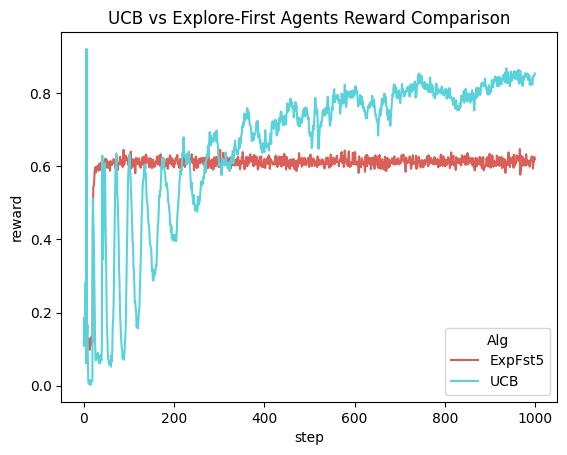

In [20]:
skewed_p = [0.1, 0.2, 0.15, 0.21, 0.3, 0.05, 0.9, 0.13, 0.17, 0.07,
            0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
# TODO: Compare UCB_Ag and ExpFstAg (max_ex=len(skewed_p)) in skewed scenario (Simple placeholder)
expfst_agent = ExpFstAg(n_act=len(skewed_p), max_ex=len(skewed_p))
ucb_agent = UCB_Ag(n_act=len(skewed_p))
# Parameters
n_runs = 1000
max_steps = 1000
# Run experiments
print("Running comparison...")
logs = []
# ExpFst
expfst_log = mab_swp([expfst_agent], skewed_p, ['ExpFst5'], n_runs=n_runs, max_steps=max_steps)
logs.append(expfst_log)
# UCB
ucb_log = mab_swp([ucb_agent], skewed_p, ['UCB'], n_runs=n_runs, max_steps=max_steps)
logs.append(ucb_log)
all_logs = pd.concat(logs)

# Plot
plot_logs(all_logs, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("UCB vs Explore-First Agents Reward Comparison")
plt.show()

**Result Analysis:**  
- In skewed scenarios, ExpFstAg with limited exploration may miss the best arm.  
- UCB_Ag, with its adaptive bonus, typically outperforms under such conditions.

## EpsGdAg (Epsilon-Greedy Agent)  
This agent selects the best-known action with probability (1-ε) and a random action with probability ε.

In [21]:
@dataclass
class EpsGdAg:
    n_act: int
    eps: float = 0.1

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.act_counts = np.zeros(self.n_act, dtype=int)
        self.Q = np.zeros(self.n_act, dtype=float)

    def update_Q(self, act, rew):
        self.act_counts[act] += 1
        self.Q[act] += (1.0 / self.act_counts[act]) * (rew - self.Q[act])

    def get_action(self):
        # ε-greedy action selection
        if np.random.rand() < self.eps:
            # Explore: choose random action
            sel_act = np.random.randint(0, self.n_act)
        else:
            # Exploit: choose best-known action
            sel_act = np.random.choice(np.flatnonzero(self.Q == self.Q.max()))
        return sel_act

**Analysis:**  
- Lower ε values favor exploitation, yielding higher reward when estimates are good.  
- Higher ε increases exploration but reduces immediate reward.  
- One strategy: decay ε over time (e.g., ε = ε₀ / t) or switch to ε = 0 after a burn-in period.

-----------

**Q:** Why does a high ε value result in lower immediate rewards?  

**A:** PUT YOUR ANSWER HERE :)

----------
**Q:** What benefits might there be in decaying ε over time?

**A:** PUT YOUR ANSWER HERE :)


Running EpsGdAg experiments with various eps values...


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

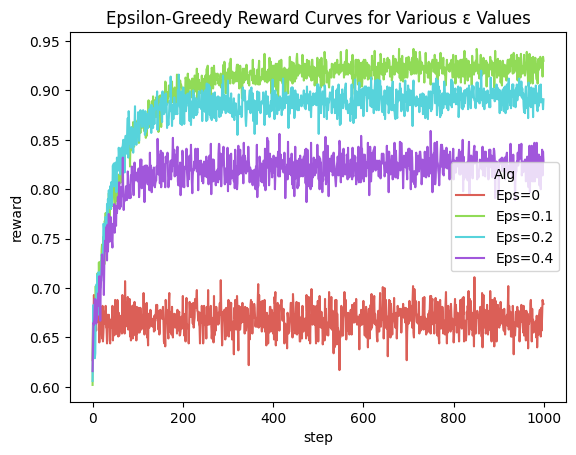

In [22]:
eps_list = [0, 0.1, 0.2, 0.4]
n_runs = 1000
max_steps = 1000
logs = []
print("Running EpsGdAg experiments with various eps values...")
for eps in eps_list:
    agent = EpsGdAg(n_act=len(p_arr), eps=eps)
    log = mab_swp([agent], p_arr, [f"Eps={eps}"], n_runs=n_runs, max_steps=max_steps)
    logs.append(log)
all_logs = pd.concat(logs)
# Plot
plot_logs(all_logs, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("Epsilon-Greedy Reward Curves for Various ε Values")
plt.show()

**Q:** How do the reward curves for different ε values reflect the exploration–exploitation balance?  

**A:** PUT YOUR ANSWER HERE :)

------------------

**Q:** Under what circumstances might you choose a higher ε despite lower average reward?

**A:** PUT YOUR ANSWER HERE :)


## Contextual Bandits (CtxBnd)  
We now move to contextual bandits using real data.  
Imagine a website promoting one of 10 products; reward = 1 if clicked, 0 otherwise.  
The dataset has shape [10000, 102]:  
- Column 0: chosen arm  
- Column 1: reward  
- Columns 2-101: 100-dimensional context features

In [23]:
# %% [code]
# Download the dataset (if not already downloaded)
!wget -q http://www.cs.columbia.edu/~jebara/6998/dataset.txt -O dataset.txt

In [49]:
# Load the dataset
ctxData = np.loadtxt('dataset.txt')
print("Dataset loaded:", ctxData.shape) 

Dataset loaded: (10000, 102)


In [50]:
@dataclass
class CtxBnd_Env:
    data: any
    t: int = 0

    def step(self, act):
        # Check if the chosen action matches the logged action
        if act + 1 == self.data[self.t, 0]:
            # Return reward if actions match
            rew = self.data[self.t, 1]
        else:
            # Return None if actions don't match
            rew = None
        
        # Increment time step
        self.t += 1
        return rew

    def reset(self):
        # Reset time step to 0
        self.t = 0

## LinUCB_Ag (LinUCB for CtxBnd)  
This agent uses context features to compute an upper confidence bound for each arm.

In [52]:
@dataclass
class LinUCB_Ag:
    n_act: int
    alpha: float
    feat_dim: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        # Initialize A matrices and b vectors for each arm
        self.As = [np.eye(self.feat_dim) for _ in range(self.n_act)]
        self.bs = [np.zeros((self.feat_dim, 1)) for _ in range(self.n_act)]

    def get_ucb(self, a, state):
        # Reshape state to column vector
        x = state.reshape(-1, 1)
        
        # Compute A inverse for the specific arm
        A_inv = np.linalg.inv(self.As[a])
        
        # Estimate theta (coefficient vector) using ridge regression
        theta = np.dot(A_inv, self.bs[a])
        
        # Compute UCB: mean estimate + confidence bonus
        p = np.dot(theta.T, x) + self.alpha * np.sqrt(np.dot(x.T, np.dot(A_inv, x)))
        
        return p[0][0]  # Return scalar value

    def update_params(self, a, rew, state):
        # If no reward (mismatched arm), do nothing
        if rew is None:
            return
        
        # Reshape state to column vector
        x = state.reshape(-1, 1)
        
        # Update A matrix for the specific arm
        self.As[a] += np.dot(x, x.T)
        
        # Update b vector for the specific arm
        self.bs[a] += rew * x

    def get_action(self, state):
        # Compute UCB estimates for all arms
        p_est = [self.get_ucb(a, state) for a in range(self.n_act)]
        
        # Find arms with maximum UCB
        max_ucb = max(p_est)
        candidate_arms = [a for a, p in enumerate(p_est) if p == max_ucb]
        
        # Randomly choose among arms with max UCB (tie-breaking)
        sel_act = np.random.choice(candidate_arms)
        
        return sel_act

**Q:** How does LinUCB leverage context to outperform classical bandit algorithms?  

**A:** PUT YOUR ANSWER HERE :)

------------------

**Q:** What is the role of the α parameter in LinUCB, and how does it affect the exploration bonus?

**A:** PUT YOUR ANSWER HERE :)

In [53]:
@dataclass
class CtxBnd_Eng:
    data: any
    agent: any

    def __post_init__(self):
        # Initialize environment with the provided data
        self.env = CtxBnd_Env(data=self.data)

    def run(self, n_runs=1):
        logs = []
        
        for _ in tqdm(range(n_runs), desc='CtxRuns'):
            aligned_ctr = []
            ret_val = 0
            valid_steps = 0
            
            # Reset environment and agent
            self.env.reset()
            self.agent.reset()
            
            # Iterate through all data points
            for t in tqdm(range(self.data.shape[0]), desc='Time'):
                # Extract state (context features)
                state = self.data[t, 2:]
                
                # Select action
                act = self.agent.get_action(state=state)
                
                # Take step in environment
                rew = self.env.step(act)
                
                # Update agent parameters
                self.agent.update_params(act, rew, state=state)
                
                # Track cumulative reward
                if rew is not None:
                    ret_val += rew
                    valid_steps += 1
                    aligned_ctr.append(ret_val / float(valid_steps))
            
            # Collect logs for this run
            logs.append(pd.DataFrame({
                'aligned_ctr': aligned_ctr, 
                'step': np.arange(len(aligned_ctr))
            }))
        
        # Combine logs from all runs
        return pd.concat(logs, ignore_index=True)

In [54]:
# %% [code]
def ctxBnd_swp(alphas, data, n_runs=1):
    logs = []
    
    # Sweep through different alpha values
    for alpha in tqdm(alphas, desc="Alpha Sweeps"):
        # Create agent and engine for each alpha
        agent = LinUCB_Ag(n_act=10, feat_dim=100, alpha=alpha)
        eng = CtxBnd_Eng(data=data, agent=agent)
        
        # Run simulation
        log_df = eng.run(n_runs)
        log_df['alpha'] = alpha
        logs.append(log_df)
    
    # Combine logs from all alpha values
    return pd.concat(logs, ignore_index=True)


In [57]:
for line_data in ctxData:

            # 1st column: Logged data arm. 
            # Integer data type
            data_arm = int(line_data.split()[0])

            # 2nd column: Logged data reward for logged chosen arm
            # Float data type
            data_reward = float(line_data.split()[1])

            # 3rd columns onwards: 100 covariates. Keep in array of dimensions (100,) with float data type
            covariate_string_list = line_data.split()[2:]
            data_x_array = np.array([float(covariate_elem) for covariate_elem in covariate_string_list])

            # Find policy's chosen arm based on input covariates at current time step
            arm_index = linucb_policy_object.select_arm(data_x_array)

            # Check if arm_index is the same as data_arm (ie same actions were chosen)
            # Note that data_arms index range from 1 to 10 while policy arms index range from 0 to 9.
            if arm_index + 1 == data_arm:

                # Use reward information for the chosen arm to update
                linucb_policy_object.linucb_arms[arm_index].reward_update(data_reward, data_x_array)

                # For CTR calculation
                aligned_time_steps += 1
                cumulative_rewards += data_reward
                aligned_ctr.append(cumulative_rewards/aligned_time_steps)

Running LinUCB sweep (Simple version)...


Alpha Sweeps:   0%|          | 0/4 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

(0, 3)

Alpha Sweeps:   0%|          | 0/4 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

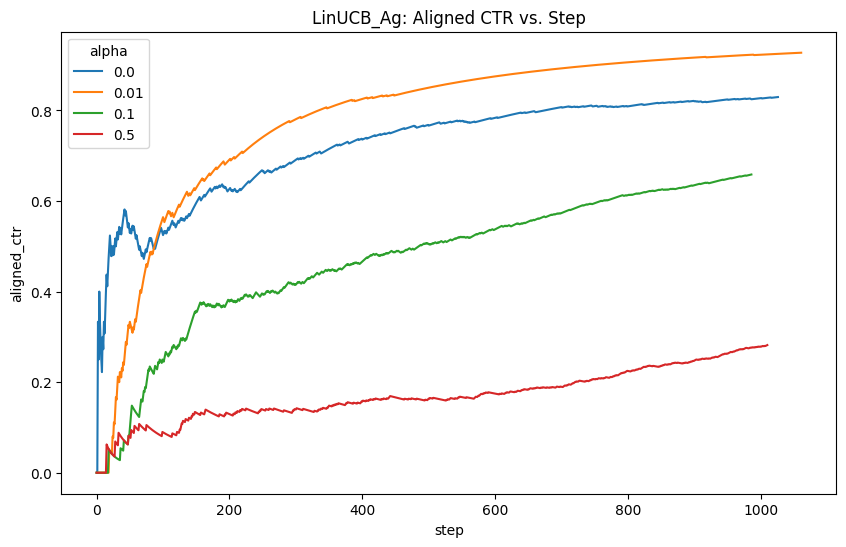

In [61]:
def plot_logs(logs, x_key='step', y_key='aligned_ctr', legend_key='alpha', estimator='mean', ci=None):
    # Pivot the logs to create a plot-friendly format
    pivot_logs = logs.pivot_table(
        index=x_key, 
        columns=legend_key, 
        values=y_key,
        aggfunc=estimator
    )
    
    # Plot the data
    pivot_logs.plot(figsize=(10, 6))
    plt.title("LinUCB_Ag: Aligned CTR vs. Step")
    plt.xlabel(x_key)
    plt.ylabel(y_key)
    plt.show()
alphas = [0, 0.01, 0.1, 0.5]
logs_ctx = ctxBnd_swp(alphas, ctxData)
plot_logs(logs_ctx)

**Q:** What does **α** affect in LinUCB?  

**A:** PUT YOUR ANSWER HERE :)

------------------

**Q:** Do the reward curves change with **α**? Explain why or why not.

**A:** PUT YOUR ANSWER HERE :)

**Q:** Based on your experiments, does LinUCB outperform the standard UCB algorithm? Why or why not?

**A:** PUT YOUR ANSWER HERE :)

------------------

**Q:** What are the key limitations of each algorithm, and how would you choose between them for a given application?

**A:** PUT YOUR ANSWER HERE :)

# Some final question
## Finite‑Horizon Regret and Asymptotic Guarantees:
Question:
Many algorithms (e.g., UCB) are analyzed using asymptotic (long‑term) regret bounds. In a finite‑horizon scenario (say, 500–1000 steps), explain intuitively why an algorithm that is asymptotically optimal may still yield poor performance. What trade‑offs arise between aggressive early exploration and cautious long‑term learning?
Deep Dive:
Discuss how the exploration bonus, tuned for asymptotic behavior, might delay exploitation in finite time, leading to high early regret despite eventual convergence.


## Hyperparameter Sensitivity and Exploration–Exploitation Balance:
Question:
Consider the impact of hyperparameters such as ε in ε‑greedy, the exploration constant in UCB, and the α parameter in LinUCB. Explain intuitively how slight mismatches in these parameters can lead to either under‑exploration (missing the best arm) or over‑exploration (wasting pulls on suboptimal arms). How would you design a self‑adaptive mechanism to balance this trade‑off in practice?
Deep Dive:
Provide insight into the “fragility” of these parameters in finite runs and how a meta‑algorithm might monitor performance indicators (e.g., variance in rewards) to adjust its exploration dynamically.


## Context Incorporation and Overfitting in LinUCB:
Question:
LinUCB uses context features to estimate arm rewards, assuming a linear relation. Intuitively, why might this linear assumption hurt performance when the true relationship is complex or when the context is high‑dimensional and noisy? Under what conditions can adding context lead to worse performance than classical (context‑free) UCB?
Deep Dive:
Discuss the risk of overfitting to noisy or irrelevant features, the curse of dimensionality, and possible mitigation strategies (e.g., dimensionality reduction or regularization).

## Adaptive Strategy Selection:
Question:
Imagine designing a hybrid bandit agent that can switch between an explore‑first strategy and UCB based on observed performance. What signals (e.g., variance of reward estimates, stabilization of Q‑values, or sudden drops in reward) might indicate that a switch is warranted? Provide an intuitive justification for how and why such a meta‑strategy might outperform either strategy alone in a finite‑time setting.
Deep Dive:
Explain the challenges in detecting when exploration is “enough” and how early exploitation might capture transient improvements even if the long‑term guarantee favors UCB.


## Non‑Stationarity and “Forgetting” Mechanisms:
Question:
In non‑stationary environments where reward probabilities drift or change abruptly, standard bandit algorithms struggle because they assume stationarity. Intuitively, explain how and why a “forgetting” or discounting mechanism might improve performance. What challenges arise in choosing the right decay rate, and how might it interact with the exploration bonus?
Deep Dive:
Describe the delicate balance between retaining useful historical information and quickly adapting to new trends, and the potential for “chasing noise” if the decay is too aggressive.

## Exploration Bonus Calibration in UCB:
Question:
The UCB algorithm adds a bonus term that decreases with the number of times an arm is pulled. Intuitively, why might a “conservative” (i.e., high) bonus slow down learning—even if it guarantees asymptotic optimality? Under what circumstances might a less conservative bonus be beneficial, and what risks does it carry?
Deep Dive:
Analyze how a high bonus may force the algorithm to continue sampling even when an arm’s estimated reward is clearly suboptimal, thereby delaying convergence. Conversely, discuss the risk of prematurely discarding an arm if the bonus is too low.


## Exploration Phase Duration in Explore‑First Strategies:
Question:
In the Explore‑First agent (ExpFstAg), how does the choice of a fixed exploration period (e.g., 5 vs. 20 steps) affect the regret and performance variability? Provide a scenario in which a short exploration phase might yield unexpectedly high regret, and another scenario where a longer phase might delay exploitation unnecessarily.
Deep Dive:
Discuss how the “optimal” exploration duration can depend heavily on the underlying reward distribution’s variance and the gap between the best and other arms, and why a one‑size‑fits‑all approach may not work in practice.


## Bayesian vs. Frequentist Approaches in MAB:
Question:
Compare the intuition behind Bayesian approaches (such as Thompson Sampling) to frequentist methods (like UCB) in handling uncertainty. Under what conditions might the Bayesian approach yield superior practical performance, and how do the underlying assumptions about prior knowledge influence the exploration–exploitation balance?
Deep Dive:
Explore the benefits of incorporating prior beliefs and the risk of bias if the prior is mis-specified, as well as how Bayesian updating naturally adjusts the exploration bonus as more data is collected.


## Impact of Skewed Reward Distributions:
Question:
In environments where one arm is significantly better (skewed probabilities), explain intuitively why agents like UCB or ExpFstAg might still struggle to consistently identify and exploit that arm. What role does variance play in these algorithms, and how might the skew exacerbate errors in reward estimation?
Deep Dive:
Discuss how the variability of rare but high rewards can mislead the agent’s estimates and cause prolonged exploration of suboptimal arms.


##Designing for High-Dimensional, Sparse Contexts:
Question:
In contextual bandits where the context is high-dimensional but only a few features are informative, what are the intuitive challenges that arise in using a linear model like LinUCB? How might techniques such as feature selection, regularization, or non-linear function approximation help, and what are the trade-offs involved?
Deep Dive:
Provide insights into the risks of overfitting versus underfitting, the increased variance in estimates from high-dimensional spaces, and the potential computational costs versus performance gains when moving from a simple linear model to a more complex one.